# NMF with better baselines 

*This notebook is an adapted version of notebook '04_XRD-with-NMF-trial.ipynb', now hopefully with better baseline information.*

%pip install h5py

%pip install xraydb

%pip install pybaselines

%pip install dask-image

In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.signal as ssg
import skimage.exposure as ske
import os
import re
import matplotlib.cm as cm 
import maxrf4u as mx
import pickle
from matplotlib.patches import Rectangle 
import sklearn.decomposition as skd 
from IPython.display import SVG 
import xraydb
from scipy.constants import c as light_speed
from scipy.constants import e as electron_charge
from scipy.constants import Planck 


from pybaselines.morphological import rolling_ball 
from dask_image.ndfilters import gaussian_filter

In [2]:
os.chdir('../..')

In [4]:
#!tree

## Our second sample `IvdW_0333329`

Our colleagues in Grenoble scanned several paint samples. 

In [8]:
h5_files = glob('../**/raw/XRD/**/*.h5', recursive=True)
for i, fn in enumerate(h5_files): 
    print(f'[{i}] {fn}')

[0] ../2024-827_Mondriaan-micro-XRD-met-Inez/data/raw/XRD/IvdW_0333329_01/IvdW_0333329_01_roi91399_107460/IvdW_0333329_01_roi91399_107460.h5
[1] ../2024-827_Mondriaan-micro-XRD-met-Inez/data/raw/XRD/IvdW_1038646_1/IvdW_1038646_1_roi91400_107461/IvdW_1038646_1_roi91400_107461.h5
[2] ../2024-827_Mondriaan-micro-XRD-met-Inez/data/raw/XRD/IvdW_90_12_X5/IvdW_90_12_X5_roi91398_107459/IvdW_90_12_X5_roi91398_107459.h5


In [55]:
second = 'IvdW_0333329_01'

In [9]:
fh = h5py.File(h5_files[0], mode='r') 

In [10]:
list_of_names = []
fh.visit(list_of_names.append)
list_of_names

['1.1',
 '1.1/eiger_average',
 '1.1/eiger_average/average',
 '1.1/eiger_average/average/2th',
 '1.1/eiger_average/average/average_intensity',
 '1.1/eiger_average/average/reference_hydrocerussite',
 '1.1/eiger_diffmap',
 '1.1/eiger_diffmap/configuration',
 '1.1/eiger_diffmap/configuration/data',
 '1.1/eiger_diffmap/configuration/type',
 '1.1/eiger_diffmap/dim0',
 '1.1/eiger_diffmap/dim1',
 '1.1/eiger_diffmap/dim2',
 '1.1/eiger_diffmap/mask_file',
 '1.1/eiger_diffmap/offset',
 '1.1/eiger_diffmap/program',
 '1.1/eiger_diffmap/result',
 '1.1/eiger_diffmap/result/2th',
 '1.1/eiger_diffmap/result/intensity',
 '1.1/eiger_diffmap/result/map',
 '1.1/eiger_integrate',
 '1.1/eiger_integrate/configuration',
 '1.1/eiger_integrate/configuration/data',
 '1.1/eiger_integrate/configuration/type',
 '1.1/eiger_integrate/integrated',
 '1.1/eiger_integrate/integrated/2th',
 '1.1/eiger_integrate/integrated/intensity',
 '1.1/eiger_integrate/integrated/points',
 '1.1/eiger_integrate/program',
 '1.1/eiger_inte

In [29]:
intensity = np.array(fh['1.1/eiger_diffmap/result/intensity']) 
x = np.array(fh['1.1/eiger_integrate/integrated/2th'])

intensity = intensity.transpose([1, 0, 2]) #rotate 90 degrees to match microscopy images
intensity = intensity[:,::-1]
intensity.shape

(170, 110, 1400)

In [30]:
x.min(), x.max()

(0.33699664947841473, 55.42159941911291)

Let's take a look at the sum map of our second sample. 

In [31]:
sum_map = np.sum(intensity, axis=2)
sum_map.shape

(170, 110)

In [32]:
%matplotlib widget

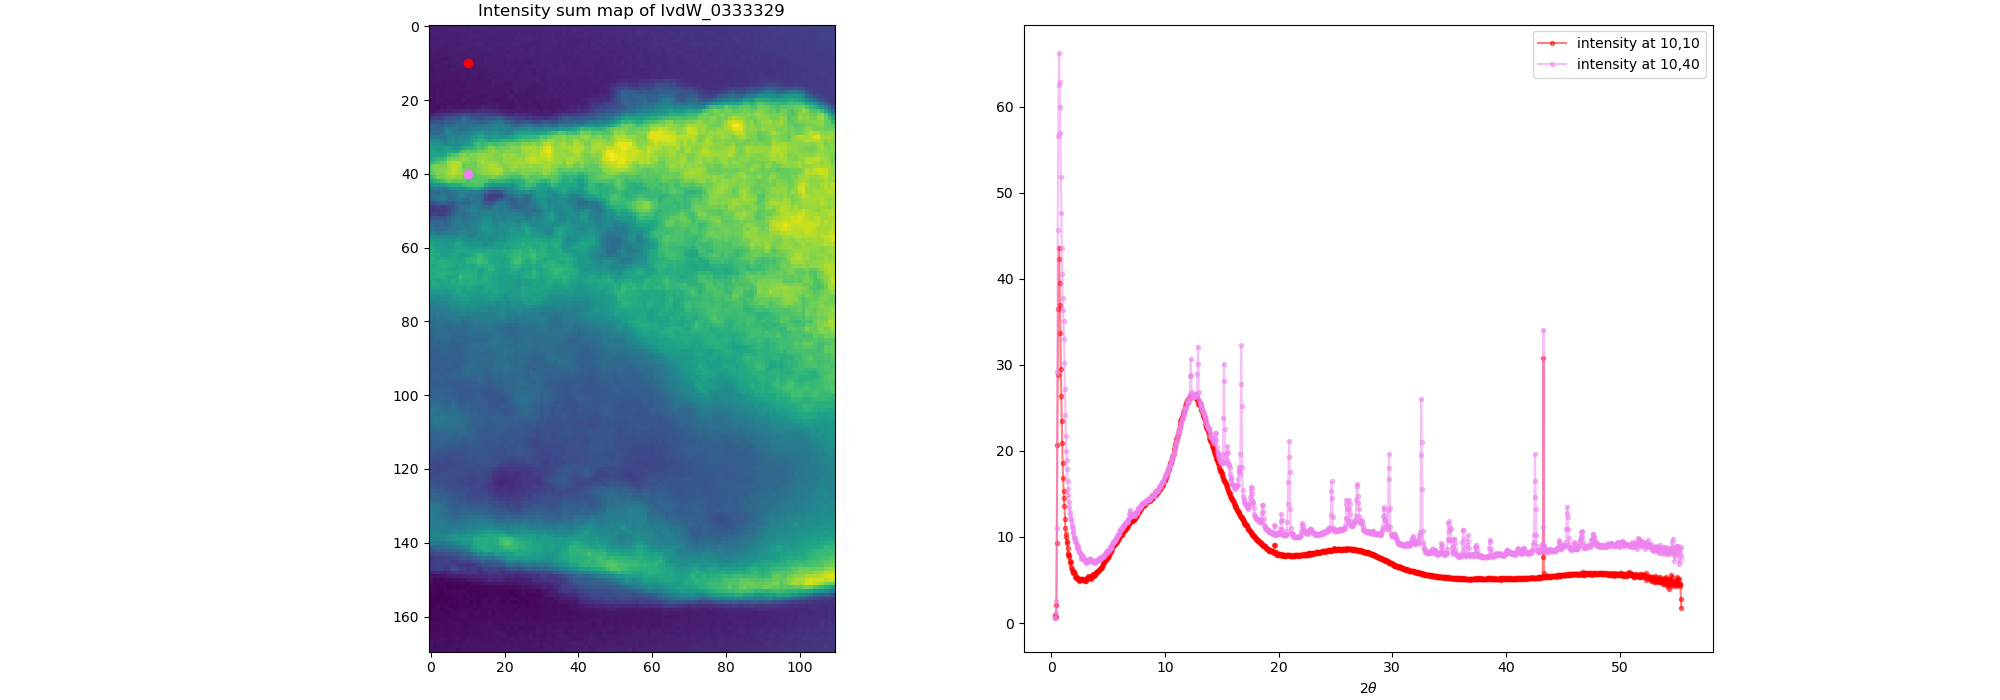

In [33]:
i1, j1 = 10, 10 
i2, j2 = 40, 10

fig, axs = plt.subplots(ncols=2, figsize=[20, 7], layout='compressed')
ax0, ax1 = axs.flatten()

ax1.sharey(ax2)
ax1.sharex(ax2)

ax0.imshow(sum_map)
ax0.set_title(f'Intensity sum map of {second}')
ax0.scatter(j1, i1, color='r')
ax0.scatter(j2, i2, color='violet')


ax1.plot(x, intensity[i1, j1], color='r', marker='o', markersize=3, alpha=0.5, label=f'intensity at {j1},{i1}')
ax1.plot(x, intensity[i2, j2], color='violet', marker='o', markersize=3, alpha=0.5, label=f'intensity at {j2},{i2}')
ax1.set_xlabel(r'$2\theta$')
ax1.legend()


Unlike our first sample, we do not find a discontinuity here. If we compare the diffractograms at the two point locations (red and violet markers) a few things can be observed. The embedding medium present at the red marker gives rise to a generally smoothly varying diffraction intensity with three major sharp peaks at $2\theta=0.7$, $19.6$, and $43.3$ radians. The smooth parts of the red and orange (embedding media) diffractograms differ by a factor $\times1.29$. 

**This confirms that the low frequency behavior of the diffractograms at the actual paint sample locations is somehow the result of the embedding medium.**  

I therefore conclude that the baseline correction that was used in notebook 04 seems quite ok. However, in addition, the spikes at $2\theta=0.7$, $19.6$, and $43.3$ radians should be filtered out before the NMF factorization. Let's take a closer look at this behavior by plotting the diffractograms for the  left and right top regions of the scan showing only the embedding medium. In this way we avoid the problematic band around x=110. 

How to filter out these spikes? Let's plot a single diffractogram and see if and how we can use the `pybaselines` package. 

In [34]:
y00 = intensity[100, 50]
b00 = rolling_ball(y00, 5)[0]

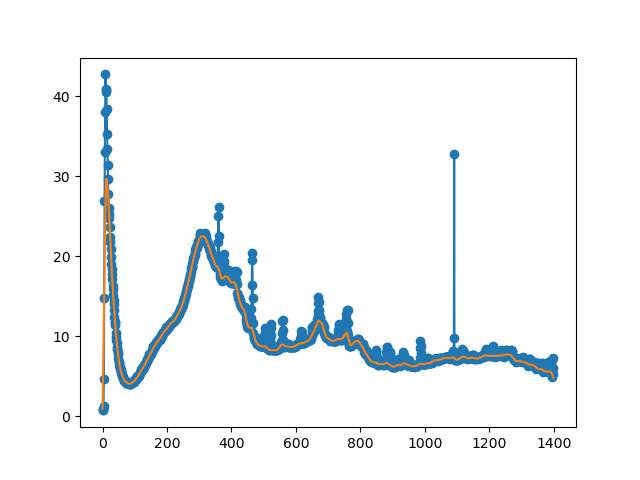

In [35]:
fig, ax = plt.subplots()

ax.plot(y00, marker='o')
ax.plot(b00) 

Let's apply the `rolling_ball()` function on the `intensity` cube and subtract the `baseline_cube` from the `intensity` cube to obtain the baseline corrected `cube`. 

In [36]:
h, w, d = intensity.shape 
baseline_cube = np.zeros_like(intensity) # initialize 

# slow code for now (takes a minute on my machine) 
radius = 5 
for i in range(h): 
    for j in range(w):
        baseline_cube[i, j] = rolling_ball(intensity[i, j], radius)[0]

cube = intensity - baseline_cube 

Next we need to clean up the diffractograms by removing spikes at the extremes plus the 44 degrees spike from the embedding. 

In [37]:
cube[:,:,0:25] = 0 # remove zero angle spike 
cube[:,:, 1380:] = 0 # remove tail noise 
cube[:,:, 1091] = 0 # remove 44 degree spike 

is_negative = cube < 0 # remove negative values 
cube[is_negative] = 0

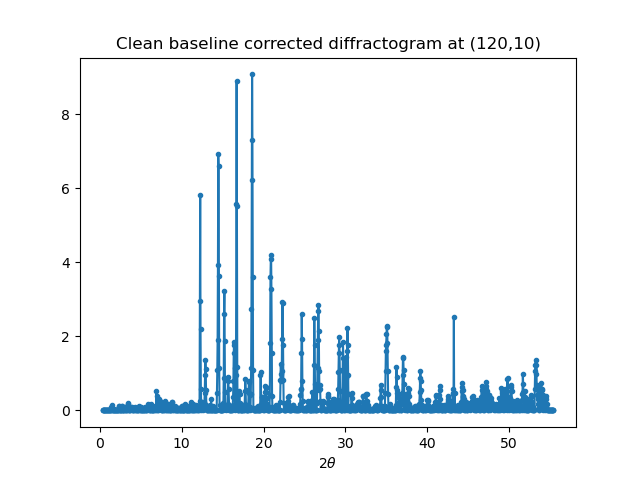

In [38]:
fig, ax = plt.subplots()
i, j  = 120, 10 
ax.plot(x, cube[i, j], marker='o', markersize=3)
ax.set_title(f'Clean baseline corrected diffractogram at ({i},{j})')
ax.set_xlabel(r'$2\theta$');

## Regions of interest 

It is problematic that we can not find cadmium sulfide phases in layers 10 and 11 as shown below. Is this due to a problem with the NMF factorization? Therefore we need to compare the complete average diffractograms for rectangular regions directly.  

In [39]:
cube_h, cube_w = cube.shape[0:2]

In [28]:
def get_xy_lims(ax): 

    j0, j1 = [int(x) for x in ax.get_xlim()]
    i1, i0 = [int(y) for y in ax.get_ylim()] 

    return i0, i1, j0, j1    

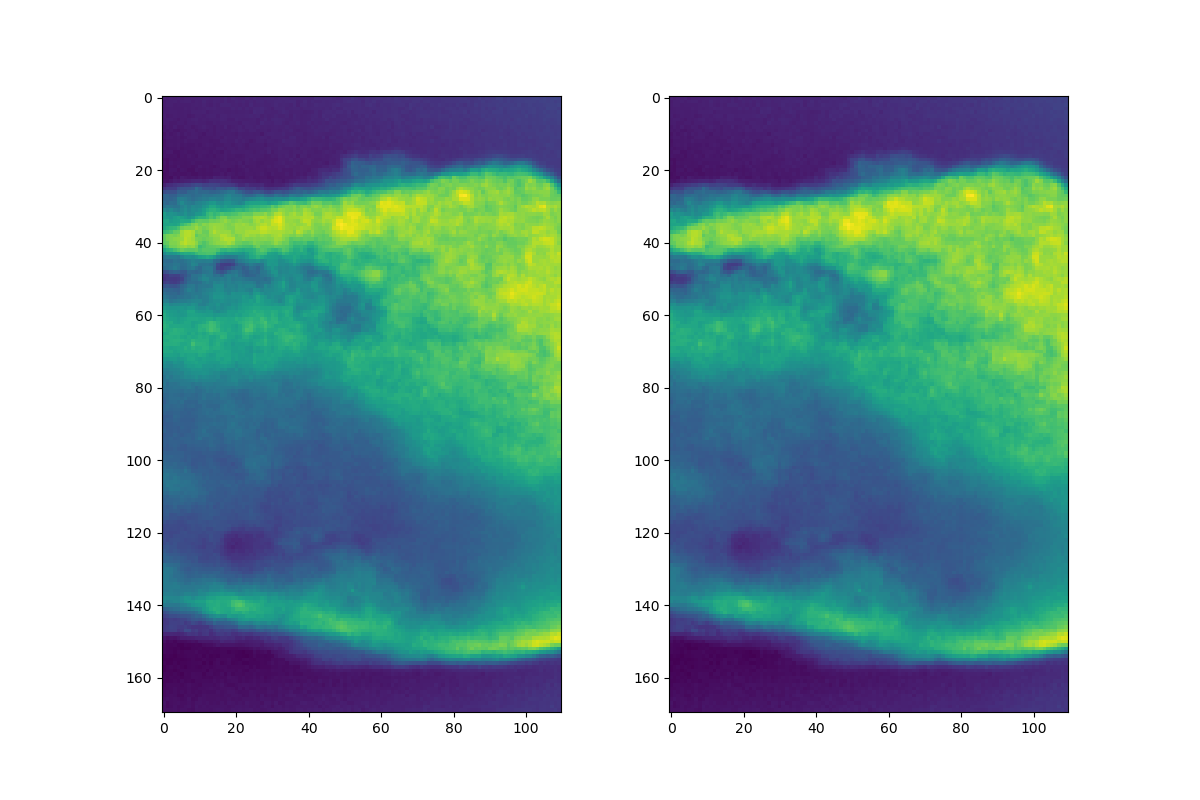

In [43]:
#layers = plt.imread('./data/microscopy/1038646-1/numbered-layers-favorite-sample.png')
fig, axs = plt.subplots(ncols=2, figsize=[12, 8])
axs = axs.flatten()
for ax in axs: 
    ax.imshow(sum_map) #, extent=[0, cube_w, cube_h, 0])

Create regions of interest in in one go. 

In [44]:
xy_lims_list = []
for ax in axs: 
    xy_lims = get_xy_lims(ax)
    xy_lims_list.append(xy_lims)

In [45]:
xy_lims_list

[(27, 52, 73, 101), (88, 125, 12, 46)]

Zoom and obtain roi indices.

In [46]:
n_regions = len(xy_lims_list)
n_regions

2

In [47]:
mean_difractogram_list = []
for xy_lims in xy_lims_list: 

    i0, i1, j0, j1 = xy_lims

    cube_roi = cube[i0:i1, j0:j1]
    mean_diffractogram = cube_roi.reshape([-1, 1400]).mean(axis=0)
    mean_diffractogram = 100 * mean_diffractogram / mean_diffractogram.max()
    mean_difractogram_list.append(mean_diffractogram)


In [48]:
region_letters = list('PQ')

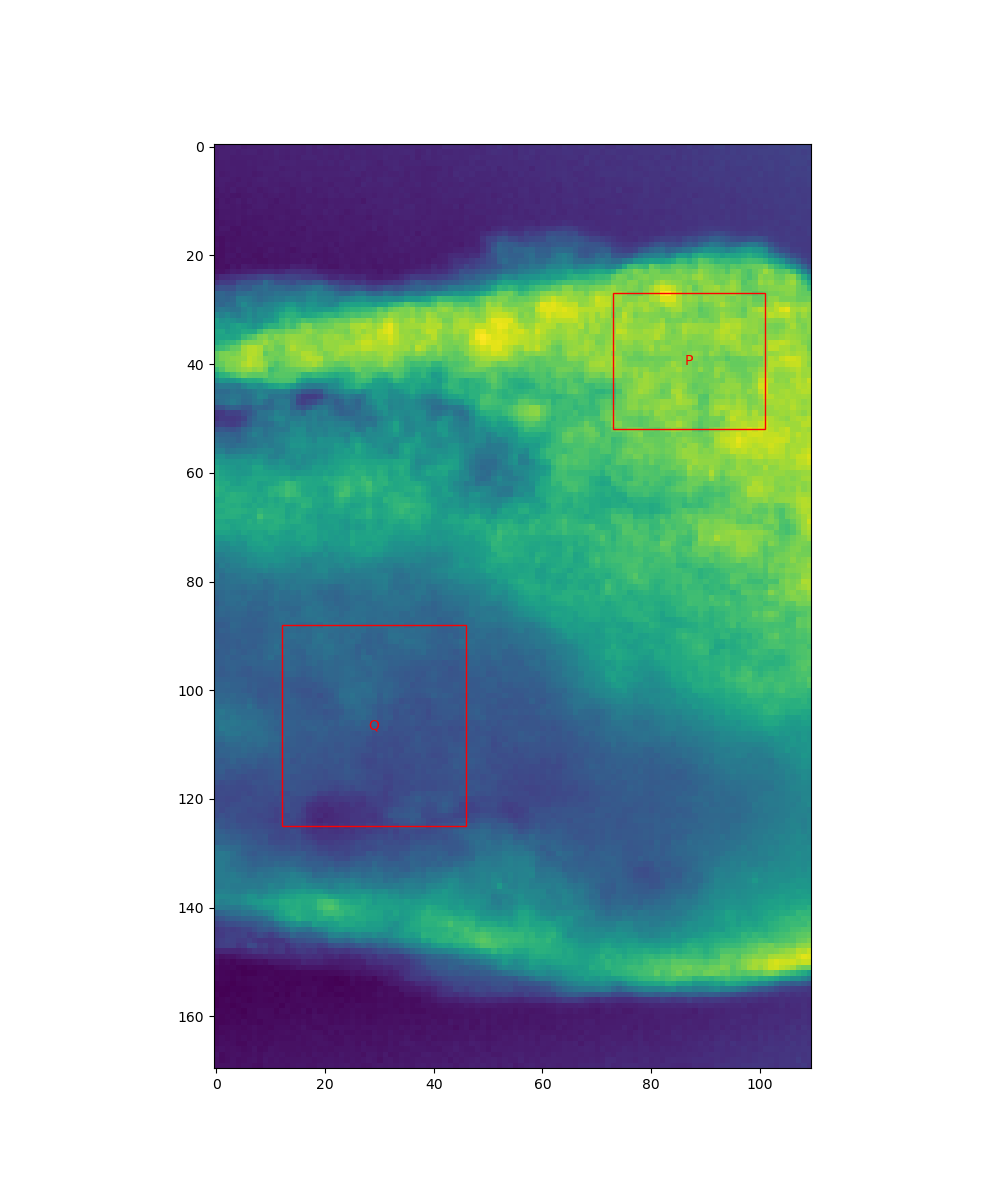

In [50]:
fig, ax = plt.subplots(figsize=[10, 12])
ax.imshow(sum_map) # extent=[0, map_w, map_h, 0])

for letter, xy_lims in zip(region_letters, xy_lims_list): 
    i0, i1, j0, j1 = xy_lims 
    ax.add_patch(Rectangle([j0, i0], j1 - j0, i1 - i0, edgecolor='r', facecolor='none'))
    ax.text(j0 + (j1 - j0)/2, i0 + (i1 - i0)/2, letter, color='r', fontsize=10, ha='center', va='center')
    

In [51]:
plt.close('all')

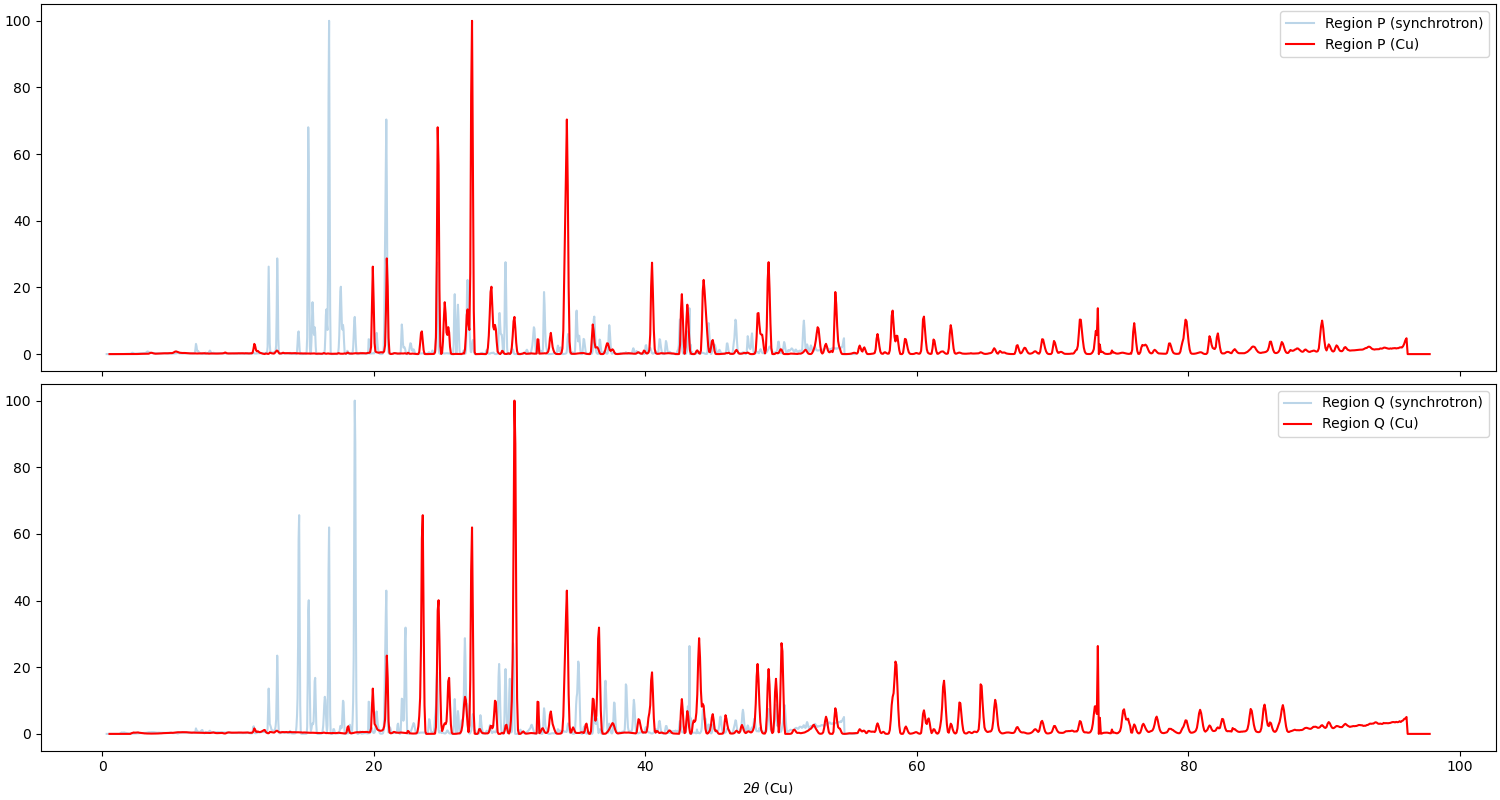

In [53]:
fig, axs = plt.subplots(nrows=2, figsize=[15, 8], sharex=True, layout='compressed') 
axs = axs.flatten()

for ax, y, rl in zip(axs, mean_difractogram_list, region_letters): 
    ax.plot(x, y, label=f'Region {rl} (synchrotron)', alpha=0.3)
    x_Cu, y_Cu = two_theta_shift(x, y, verbose=False)
    
    ax.plot(x_Cu, y_Cu, color='r', label=f'Region {rl} (Cu)')
    ax.legend()
ax.set_xlabel(r'$2\theta$ (Cu)');


## Old code

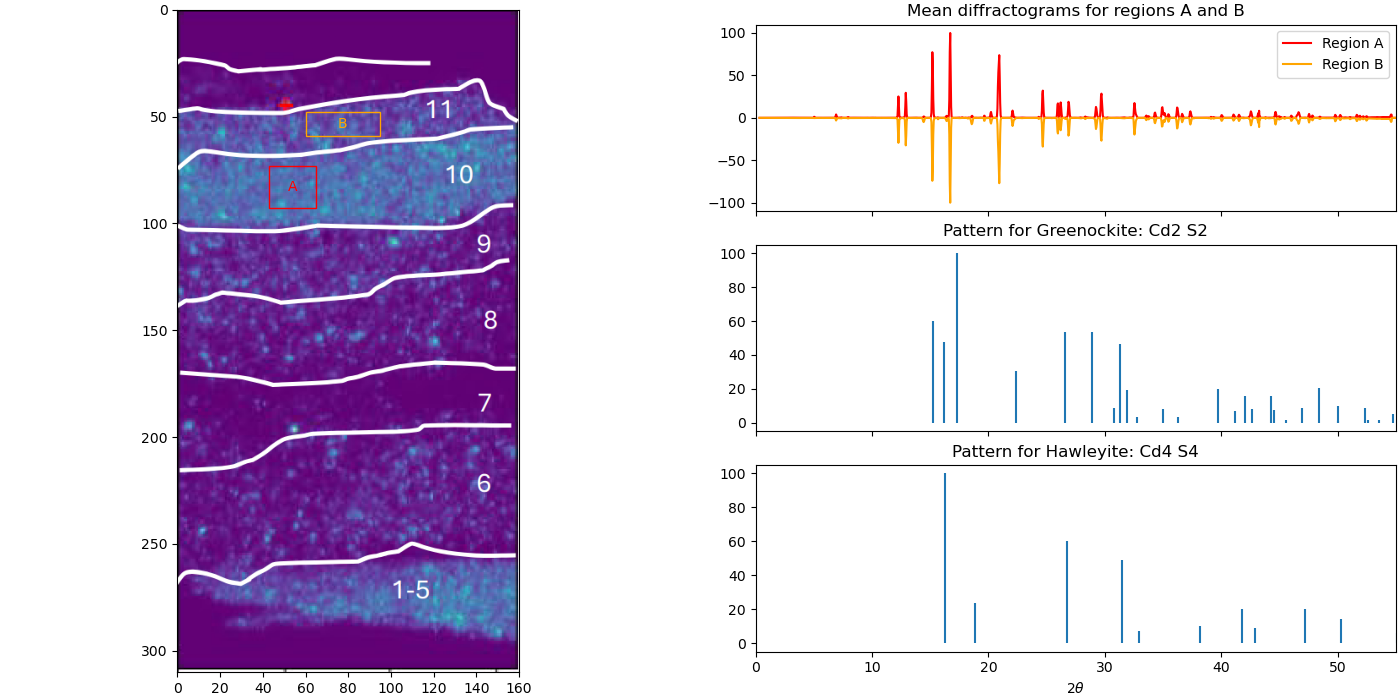

In [44]:
# region A
i0_A, i1_A, j0_A, j1_A = (73, 93, 43, 65)
cube_roi_A = cube[i0_A:i1_A, j0_A:j1_A]
mean_diffractogram_A = cube_roi_A.reshape([-1, 1400]).mean(axis=0)
mean_diffractogram_A = 100 * mean_diffractogram_A / mean_diffractogram_A.max()


# region B
i0_B, i1_B, j0_B, j1_B = (48, 59, 60, 95)
cube_roi_B = cube[i0_B:i1_B, j0_B:j1_B]
mean_diffractogram_B = cube_roi_B.reshape([-1, 1400]).mean(axis=0)
mean_diffractogram_B = 100 * mean_diffractogram_B / mean_diffractogram_B.max()



fig = plt.figure(layout='compressed', figsize=[14, 7])
subfigs = fig.subfigures(1, 2, wspace=0.01)

# left  
ax_im = subfigs[0].subplots() 
ax_im.add_patch(Rectangle([j0_A, i0_A], j1_A - j0_A, i1_A - i0_A, edgecolor='r', facecolor='none'))
ax_im.text(j0_A + (j1_A - j0_A)/2, i0_A + (i1_A - i0_A)/2, 'A', color='r', fontsize=10, ha='center', va='center')

ax_im.add_patch(Rectangle([j0_B, i0_B], j1_B - j0_B, i1_B - i0_B, edgecolor='orange', facecolor='none'))
ax_im.text(j0_B + (j1_B - j0_B)/2, i0_B + (i1_B - i0_B)/2, 'B', color='orange', fontsize=10, ha='center', va='center')

ax_im.imshow(layers, extent=[0, map_w, map_h, 0]) 

# right
axs = subfigs[1].subplots(nrows=3, sharex=True)
ax0, ax1, ax2 = axs.flatten()


n = 24
ax0.set_xlim([0, 55])
ax0.plot(x, mean_diffractogram_A, color='r', label='Region A')
ax0.plot(x, -mean_diffractogram_B, color='orange', label='Region B')
ax0.set_title('Mean diffractograms for regions A and B')

n = 24 #
ax1.set_title(f'Pattern for {df['name'][n]}: {df['formula'][n]}')
ax1.vlines(patterns[n].x, np.zeros_like(patterns[n].y), patterns[n].y)

n = 28 #
ax2.set_title(f'Pattern for {df['name'][n]}: {df['formula'][n]}')
ax2.vlines(patterns[n].x, np.zeros_like(patterns[n].y), patterns[n].y)
ax2.set_xlabel(r'$2\theta$')

ax0.legend()

**It seems that we are forced to conclude that that diffraction data seems to indicate that cadmium sulfide phases Grenockite and Hawleyite are not present in layers 10 and 11.** 

In [173]:
plt.close('all')

Let's explore the discontinuity in our favorite sample a bit further. 

## Image registration (front versus back)

Most interesting! It is clear that a single paint layer can contain a large number of crystal phases. With these high contrast images we are now in a better position to register with our microscopy images. Perhaps our best image is the polypol map. So let's export this.  

## Cu shifted xy-files for mean diffractograms of regions A-F

To create xy files for the 6 regions A-F I need these functions. 

In [52]:
from scipy.interpolate import interp1d

synchrotron_wavelength = 0.9510908054342373 
Cu_wavelength = 1.540884610730401 # Angstroms 

def two_theta_shift(ptrn_x, ptrn_y, old_wavelength=synchrotron_wavelength, new_wavelength=Cu_wavelength, verbose=True): 
    '''Shift `x` two theta pattern angles (in degrees) from `old_wavelength` to `new_wavelength` (in Angstroms). 
    
    Mask invalid angles that would be shifted beyond 180 degrees.'''

    ratio = new_wavelength / old_wavelength
    z = ratio * np.sin(np.deg2rad(ptrn_x) / 2)
    is_valid = z < 1
                
    new_x = 2 * np.rad2deg(np.arcsin(z[is_valid]))
    new_y = ptrn_y[is_valid]

    if verbose: 
        n_invalid = np.sum(~is_valid)
        print(f'Discarding {n_invalid} angles.')

    return new_x, new_y


def interpolate(x, y): 

    f = interp1d(x, y)
    x_lin = np.arange(1, 55, 0.1)
    y_lin = f(x_lin)

    return x_lin, y_lin

def write_xy_file(x, y, filename, comment='# Frank was here\n'):

    with open(filename, 'w') as fh: 
        fh.write(comment)

        for xi, yi in zip(x, y): 
            line = f'{xi:.03f} {yi:.04f}\n'
            fh.write(line)
               

In [56]:
second

'IvdW_0333329_01'

In [57]:
xy_filenames = [f'./data/interim/region-xy-files/IvdW_1038646_1/region-{rl}.xy' for rl in region_letters] 
xy_filenames

['./data/interim/region-xy-files/IvdW_1038646_1/region-P.xy',
 './data/interim/region-xy-files/IvdW_1038646_1/region-Q.xy']

In [58]:
for d, f in zip(mean_difractogram_list, xy_filenames): 

    new_x, new_y = two_theta_shift(x, y, synchrotron_wavelength, Cu_wavelength)
    lin_x, lin_y = interpolate(new_x, new_y)
    
    write_xy_file(lin_x, lin_y, filename=f)

Discarding 0 angles.
Discarding 0 angles.


## Matching with cif data 

In [45]:
favorite

'IvdW_1038646_1'

In [47]:
from scipy.interpolate import interp1d

synchrotron_wavelength = 0.9510908054342373 
Cu_wavelength = 1.540884610730401 # Angstroms 

def two_theta_shift(ptrn_x, ptrn_y, old_wavelength, new_wavelength, verbose=True): 
    '''Shift `x` two theta pattern angles (in degrees) from `old_wavelength` to `new_wavelength` (in Angstroms). 
    
    Mask invalid angles that would be shifted beyond 180 degrees.'''

    ratio = new_wavelength / old_wavelength
    z = ratio * np.sin(np.deg2rad(ptrn_x) / 2)
    is_valid = z < 1
                
    new_x = 2 * np.rad2deg(np.arcsin(z[is_valid]))
    new_y = ptrn_y[is_valid]

    if verbose: 
        n_invalid = np.sum(~is_valid)
        print(f'Discarding {n_invalid} angles.')

    return new_x, new_y


def interpolate(x, y): 

    f = interp1d(x, y)
    x_lin = np.arange(1, 55, 0.1)
    y_lin = f(x_lin)

    return x_lin, y_lin

def write_xy_file(x, y, filename, comment='\'Id: "?" Comment: "?" Operator: "?" Anode: "CU" Scantype: "?" TimePerStep: "120" \n'):

    with open(filename, 'w') as fh: 
        fh.write(comment)

        for xi, yi in zip(x, y): 
            line = f'{xi:.03f} {yi:.04f}\n'
            fh.write(line)
               

Although we downloaded the complete COD database, I am still struggling to create a table or database to search from. For now, let's work with the set of unique crystal structures downloaded from the AMSCD database. See notebook 07. And create an overview of all diffractograms. 

In [35]:
from glob import glob
from pymatgen.core import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import matplotlib.pyplot as plt 
import numpy as np 
import polars as pl
import os
pl.Config.set_tbl_rows(-1);

In [36]:
unique_cif_files = ['Lanarkite_0010717.cif',
 'Pb3O2(CO3)\r_0014552.cif',
 'Anglesite_0000665.cif',
 'Calcite_0000098.cif',
 'Thenardite_0005113.cif',
 'CadmiumOxalate_2012182.cif',
 'Shannonite_0014550.cif',
 'Glikinite_0020988.cif',
 'Sphalerite_0000110.cif',
 'Vaterite_0004854.cif',
 'CdCl2_0011804.cif',
 'Na2 O3 S\r_0017434.cif',
 'CadmiumChlorideHydrated_2106702.cif',
 'Magnesite_0000099.cif',
 'Sclarite_01317.cif',
 'Hydrocerussite_0009160.cif',
 'Pb3O2(CO3)_0014552.cif',
 'Wurtzite-2H_0010082.cif',
 'Huntite_0001006.cif',
 'cadmiumHydroxyChloride_1010263.cif',
 'Otavite_0000103.cif',
 'Dolomite_0000086.cif',
 'CdCl2\r_0011804.cif',
 'CadmiumHydroxySulphate_2107256.cif',
 'Greenockite_0011540.cif',
 'CadmiumSulphateMonohydrated_2241132.cif',
 'Na2 O4 S\r_0017433.cif',
 'Na2 O3 S_0017434.cif',
 'Hawleyite_0000070.cif',
 'Baryte_0000164.cif',
 'Zincite_0005203.cif',
 'Wurtzite-4H_0005544.cif',
 'Wurtzite-15R_0015414.cif',
 'CadmiumSulphateHydroxyHydrated_1525852.cif',
 'Na2 O4 S_0017433.cif',
 'CadmiumSulphiteHydrated_1541695.cif',
 'CadmiumSulphate_1533737.cif',
 'Wurtzite-10H_0000088.cif',
 'Scotlandite_0015703.cif',
 'Wurtzite_0015179.cif',
 'Zinkosite_0009208.cif',
 'Barite_0000163.cif',
 'Wurtzite-6H_0000115.cif',
 'CadmiumChlorideHydrated25_2106551.cif',
 'Cerussite_0006304.cif',
 'Wurtzite-8H_0000089.cif',
 '(CdSO4)3(H2O)8_1010534.cif',
 'Aragonite_0000233.cif']

Let's try to parse the structures for each unique cif file. 

In [37]:
prefix = 'data/AMCSD-data/amscd-cif-files/'

In [38]:
cif_files = [f'{prefix}{cf}' for cf in unique_cif_files]
len(cif_files)

48

In [43]:
structures = []
formulas = []
cif_nums = []
names = []
for cf in cif_files: 
    #print(f'Parsing: {cf}')
    try: 
        s = Structure.from_file(cf)
        structures.append(s)
        f = s.alphabetical_formula
        formulas.append(f)
        n = os.path.basename(cf)
        cif_nums.append(n)
        names.append(re.split('_', os.path.basename(cf))[0])
    except: 
        print(f'Error parsing: {cf}') 

df = pl.DataFrame({'formula': formulas, 'cif': cif_nums, 'name': names})
df.with_row_index()

shape: (48, 4)
┌───────┬─────────────────┬─────────────────────────────────┬────────────────────────────────┐
│ index ┆ formula         ┆ cif                             ┆ name                           │
│ ---   ┆ ---             ┆ ---                             ┆ ---                            │
│ u32   ┆ str             ┆ str                             ┆ str                            │
╞═══════╪═════════════════╪═════════════════════════════════╪════════════════════════════════╡
│ 0     ┆ O20 Pb8 S4      ┆ Lanarkite_0010717.cif           ┆ Lanarkite                      │
│ 1     ┆ C8 O40 Pb24     ┆ Pb3O2(CO3)
_0014552.cif         ┆ Pb3O2(CO3)
                    │
│ 2     ┆ O16 Pb4 S4      ┆ Anglesite_0000665.cif           ┆ Anglesite                      │
│ 3     ┆ C6 Ca6 O18      ┆ Calcite_0000098.cif             ┆ Calcite                        │
│ 4     ┆ Na16 O32 S8     ┆ Thenardite_0005113.cif          ┆ Thenardite                     │
│ 5     ┆ C4 Cd2 O8       ┆ CadmiumOxalate_2012182.cif      ┆ CadmiumOxalate                 │
│ 6     ┆ C4 O16 Pb8      ┆ Shannonite_0014550.cif          ┆ Shannonite                     │
│ 7     ┆ O18 S4 Zn6      ┆ Glikinite_0020988.cif           ┆ Glikinite                      │
│ 8     ┆ S4 Zn4          ┆ Sphalerite_0000110.cif          ┆ Sphalerite                     │
│ 9     ┆ C18 Ca18 O54    ┆ Vaterite_0004854.cif            ┆ Vaterite                       │
│ 10    ┆ Cd3 Cl6         ┆ CdCl2_0011804.cif               ┆ CdCl2                          │
│ 11    ┆ Na4 O6 S2       ┆ Na2 O3 S
_0017434.cif           ┆ Na2 O3 S
                      │
│ 12    ┆ Cd4 Cl8 O4      ┆ CadmiumChlorideHydrated_210670… ┆ CadmiumChlorideHydrated        │
│ 13    ┆ C6 Mg6 O18      ┆ Magnesite_0000099.cif           ┆ Magnesite                      │
│ 14    ┆ C8 H40 O64 Zn28 ┆ Sclarite_01317.cif              ┆ Sclarite                       │
│ 15    ┆ C6 O24 Pb9      ┆ Hydrocerussite_0009160.cif      ┆ Hydrocerussite                 │
│ 16    ┆ C8 O40 Pb24     ┆ Pb3O2(CO3)_0014552.cif          ┆ Pb3O2(CO3)                     │
│ 17    ┆ S2 Zn2          ┆ Wurtzite-2H_0010082.cif         ┆ Wurtzite-2H                    │
│ 18    ┆ C12 Ca3 Mg9 O36 ┆ Huntite_0001006.cif             ┆ Huntite                        │
│ 19    ┆ Cd2 Cl2 H2 O2   ┆ cadmiumHydroxyChloride_1010263… ┆ cadmiumHydroxyChloride         │
│ 20    ┆ C6 Cd6 O18      ┆ Otavite_0000103.cif             ┆ Otavite                        │
│ 21    ┆ C6 Ca3 Mg3 O18  ┆ Dolomite_0000086.cif            ┆ Dolomite                       │
│ 22    ┆ Cd3 Cl6         ┆ CdCl2
_0011804.cif              ┆ CdCl2
                         │
│ 23    ┆ Cd8 O24 S4      ┆ CadmiumHydroxySulphate_2107256… ┆ CadmiumHydroxySulphate         │
│ 24    ┆ Cd2 S2          ┆ Greenockite_0011540.cif         ┆ Greenockite                    │
│ 25    ┆ Cd4 H8 O20 S4   ┆ CadmiumSulphateMonohydrated_22… ┆ CadmiumSulphateMonohydrated    │
│ 26    ┆ Na8 O16 S4      ┆ Na2 O4 S
_0017433.cif           ┆ Na2 O4 S
                      │
│ 27    ┆ Na4 O6 S2       ┆ Na2 O3 S_0017434.cif            ┆ Na2 O3 S                       │
│ 28    ┆ Cd4 S4          ┆ Hawleyite_0000070.cif           ┆ Hawleyite                      │
│ 29    ┆ Ba4 O16 S4      ┆ Baryte_0000164.cif              ┆ Baryte                         │
│ 30    ┆ O2 Zn2          ┆ Zincite_0005203.cif             ┆ Zincite                        │
│ 31    ┆ S4 Zn4          ┆ Wurtzite-4H_0005544.cif         ┆ Wurtzite-4H                    │
│ 32    ┆ S15 Zn15        ┆ Wurtzite-15R_0015414.cif        ┆ Wurtzite-15R                   │
│ 33    ┆ Cd16 O46 S4     ┆ CadmiumSulphateHydroxyHydrated… ┆ CadmiumSulphateHydroxyHydrated │
│ 34    ┆ Na8 O16 S4      ┆ Na2 O4 S_0017433.cif            ┆ Na2 O4 S                       │
│ 35    ┆ Cd16 O72 S16    ┆ CadmiumSulphiteHydrated_154169… ┆ CadmiumSulphiteHydrated        │
│ 36    ┆ Cd4 O16 S4      ┆ CadmiumSulphate_1533737.cif     ┆ CadmiumSulphate             

In [40]:
n_structures = len(structures)
n_structures

48

In [41]:
synchrotron_wavelength = 9.510908054342373e-1 # as reported in json AND CONVERTED TO Angstroms!!! 
#alpha = 1.025
alpha = 1
patterns = [XRDCalculator(wavelength=synchrotron_wavelength * alpha).get_pattern(s) for s in structures]

In [42]:
W.shape

(30, 1400)

Text(0.5, 1.0, 'Hawleyite')

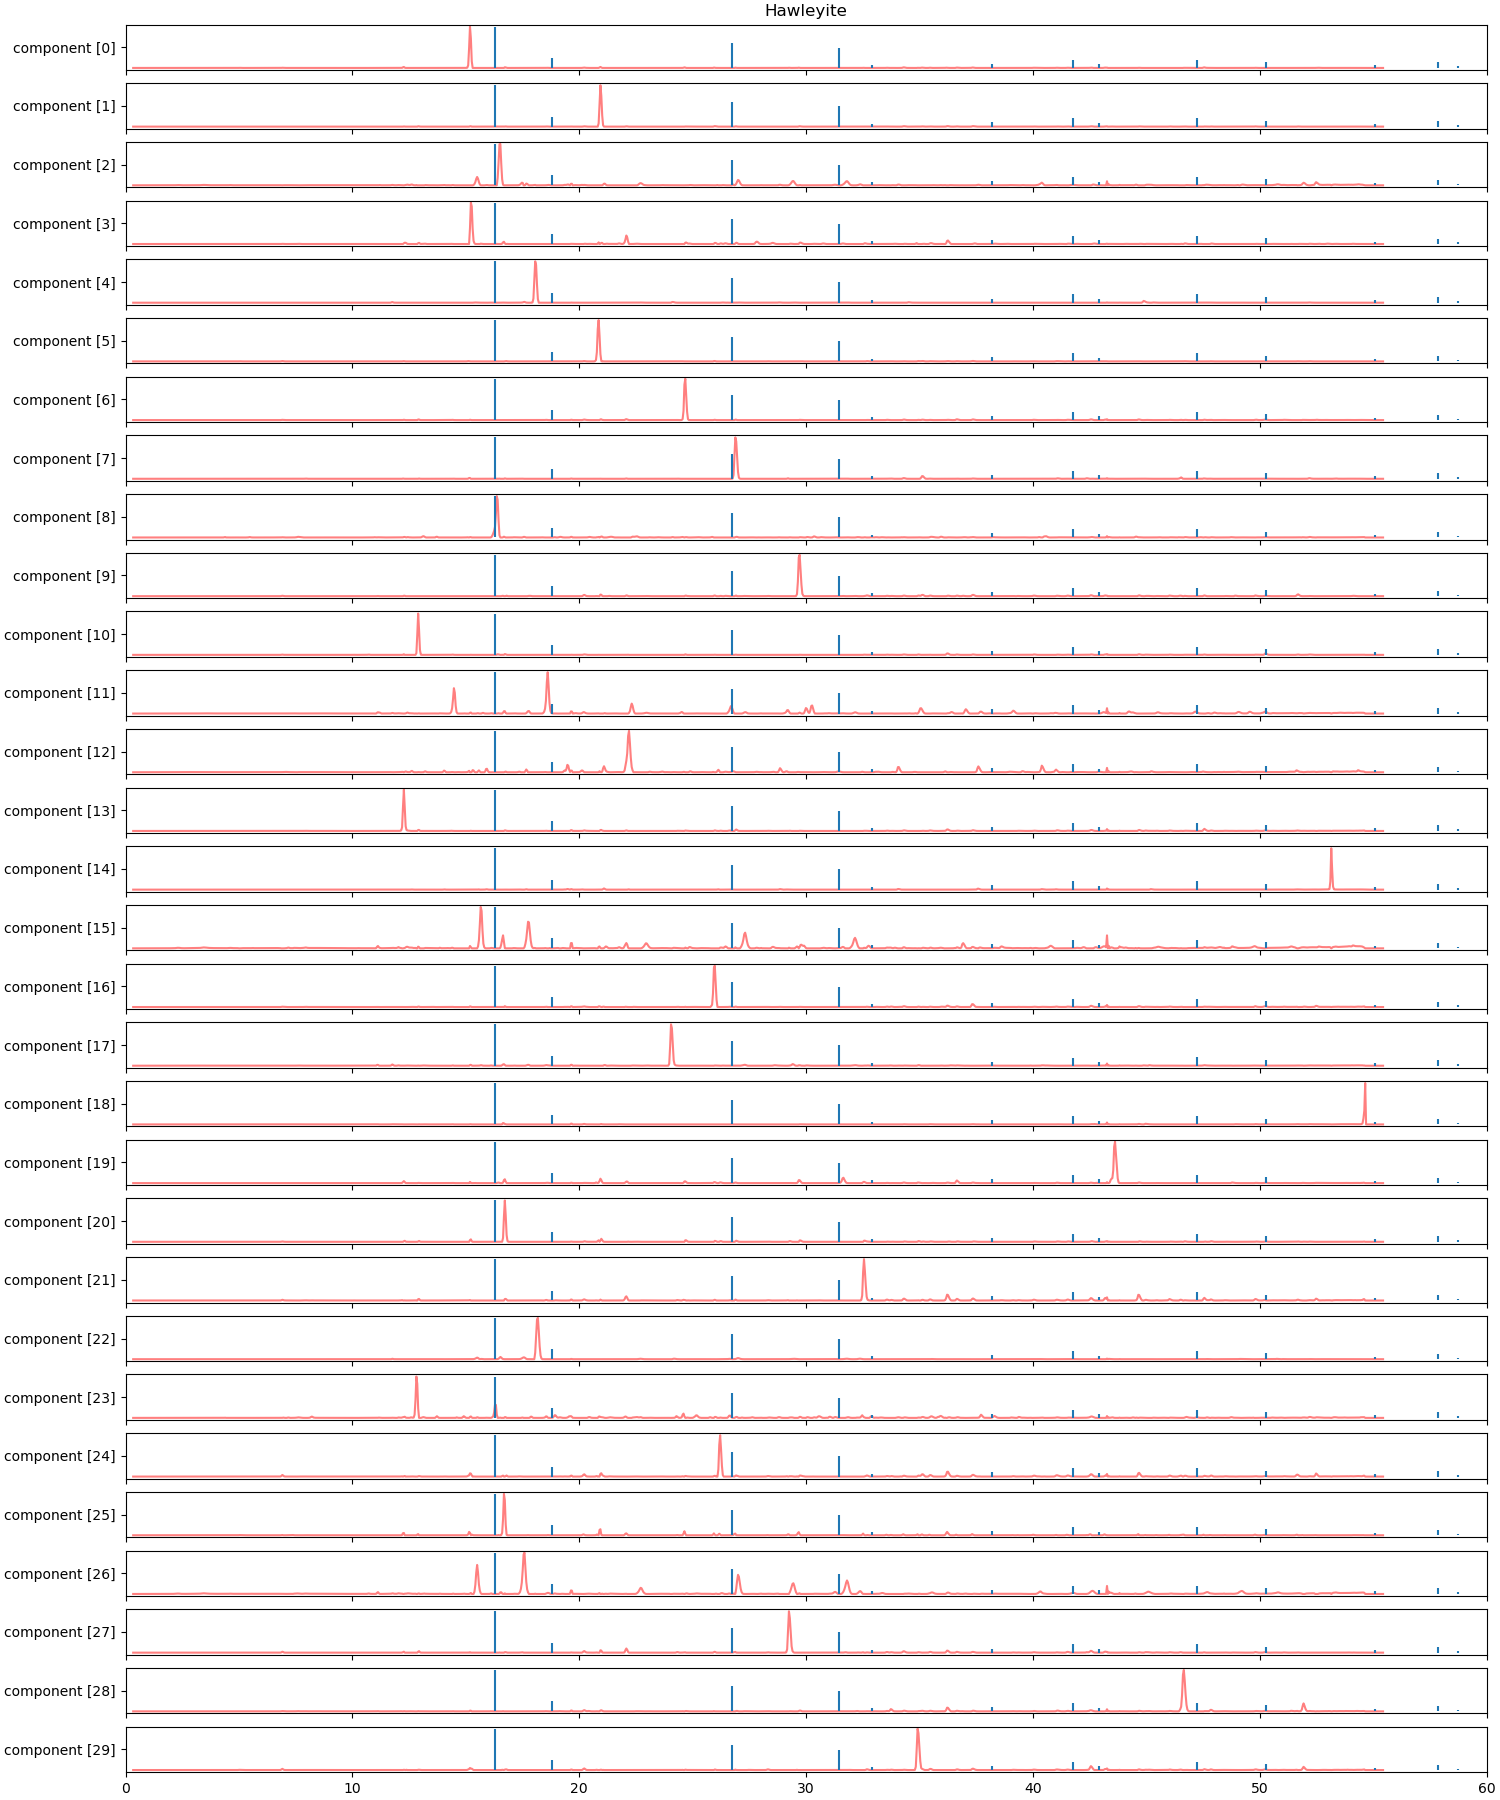

In [96]:
n = 28

n_components = len(W)

fig, axs = plt.subplots(nrows=n_components, figsize=[15, 18], layout='constrained', sharex=True)

axs = axs.flatten()

for i, [ax, w] in enumerate(zip(axs, W)):

    ax.plot(x, 100* w / max(w), color='r', alpha=0.5)
    ax.vlines(patterns[n].x, np.zeros_like(patterns[n].y), patterns[n].y)
    ax.set_xlim(0, 60)
    ax.set_yticks([50])
    ax.set_yticklabels([f'component [{i}]'])

axs[0].set_title(names[n])

Comparison with AMCDS diffraction data:

Conclusion so far is that NMF components `[5]` and `[19]` correspond with Cd2S2 Greenockite, with certain unknown concentrations of Zn.  

## Image registration 

In [390]:
SVG('data/raw/microscopy/1038646-1/1038646-1_registration.svg')

## Converting synchrotron wavelength to copper 

The Bragg condition should make it fairly simple to convert the measured diffraction pattern to another wavelength. Afterwards we can check this with the `XRDCalculator`.

Here is the Bragg condition, which holds for the synchrotron wavelength $\lambda_{s}$ and the synchrotron angle $\theta_{s}$.

$$ n \lambda_{s} = 2 d \sin \theta_{s} \tag{1} $$

This condition, with the same lattice distance $d$ also holds for the Cu Ka wavelength $\lambda_{cu}$ and Cu Ka angle $\theta_{cu}$

Combining these two equations and eliminating d should allow is the express $\theta_{cu}$ as a function of $\theta_{s}$...

$$ \theta_{cu} = \arcsin (\frac{\lambda_{cu}}{\lambda_{s}} \sin(\theta_{s})) $$

Expressed as two theta we get: 

$$ 2 \theta_{cu} = 2 \arcsin(\frac{\lambda_{cu}}{\lambda_s} \sin(\theta_{s})) $$

In [120]:
np.pi

3.141592653589793

In [122]:
theta_rad = np.pi * x / 360
theta_rad

array([0.00294085, 0.00328446, 0.00362806, ..., 0.48295748, 0.48330109,
       0.48364469])

In [126]:
Cu = xraydb.xray_lines('Cu')

In [142]:
Cu_wavelength =  1e10 * Planck * light_speed / (Cu['Ka1'].energy * electron_charge) # Angstroms

In [148]:
Cu_wavelength = 1.540884610730401 # Angstroms 

In [144]:
syn_wavelength = 9.510908054342373e-1 # as reported in json AND CONVERTED TO Angstroms!!! 

In [155]:
Cu_two_theta = 180 * ((2 * np.arcsin((Cu_wavelength / syn_wavelength) * np.sin(theta_rad))) / np.pi)

In [156]:
Cu_two_theta

array([ 0.54597749,  0.60976917,  0.67356097, ..., 97.5949819 ,
       97.6807755 , 97.76662714])

In [194]:
def two_theta_shift(x, y, old_wavelength, new_wavelength): 
    '''Shift `x` two theta pattern angles (in degrees) from `old_wavelength` to `new_wavelength` (in Angstroms). 
    
    Mask invalid angles that would be shifted beyond 180 degrees.'''

    ratio = new_wavelength / old_wavelength

    z = ratio * np.sin(np.deg2rad(twotheta) / 2)

    is_valid = z < 1
                

    new_x = 2 * np.rad2deg(np.arcsin(z[is_valid]))
    new_y = y[is_valid]

    return new_x, new_y

In [195]:
new_x, new_y = two_theta_shift(synchrotron_pattern.x, synchrotron_pattern.y, synchrotron_wavelength, Cu_wavelength)